## Import packages

In [15]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
from scipy import interpolate
import ERA5_functions as era_fncts
import pandas as pd
from random import randint

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [3]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [4]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [5]:
aht_ds = xr.open_dataset('aht_time_series/era5_aht_time_series.nc')

In [41]:
### Load in the necessary single lat AHT files

which_lat1 = 40
which_lat2 = 60

ddir = 'aht_time_series/one_lat/'
eddy_files1 = sorted(glob(ddir + 'eddy_total_' + str(which_lat1) +'*'))
eddy_files2 = sorted(glob(ddir + 'eddy_total_' + str(which_lat2) + '*'))

eddy_data1 = []
for eddy in eddy_files1:
    file_data = np.load(eddy)
    eddy_data1.append(file_data)

eddy_local1 = np.concatenate(eddy_data1) * geometry[era_fncts.get_lat_idx(which_lat1)]

eddy_data2 = []
for eddy in eddy_files2:
    file_data = np.load(eddy)
    eddy_data2.append(file_data)

eddy_local2 = np.concatenate(eddy_data2) * geometry[era_fncts.get_lat_idx(which_lat2)]

### Choose whether or not to de-seasonalize the local AHT

In [42]:
#eddy_local1 = eddy_local1
#eddy_local2 = eddy_local2

eddy_local_no_seas1 = np.zeros_like(eddy_local1)
eddy_local_no_seas2 = np.zeros_like(eddy_local2)

for i in range(len(lons)):
    eddy_local_no_seas1[:,i] = era_fncts.remove_seasons_spline(eddy_local1[:,i], num_knots=6, periodic=True)[0]
    eddy_local_no_seas2[:,i] = era_fncts.remove_seasons_spline(eddy_local2[:,i], num_knots=6, periodic=True)[0]
    
eddy_local1 = eddy_local_no_seas1
eddy_local2 = eddy_local_no_seas2

### Get decorrelation length scale info

In [8]:
decorr_dict = np.load('decorr_dict.npy',allow_pickle='TRUE').item()


try:
    decorr_info1 = decorr_dict[str(which_lat1)]
except:
    decorr_info1 = era_fncts.decorr_length_scale(eddy_local1)
    decorr_dict[str(which_lat1)] = decorr_info1

try:
    decorr_info2 = decorr_dict[str(which_lat2)]
except:
    decorr_info2 = era_fncts.decorr_length_scale(eddy_local2)
    decorr_dict[str(which_lat2)] = decorr_info2
    
np.save('decorr_dict.npy', decorr_dict) 

### Randomly sample the points

In [9]:
eddy_local1_samples = np.empty(len(eddy_local1[:,0]))
lon_samples = np.empty(720)
#For each time take a random sample at every longitude
for i in range(len(eddy_local1[:,0])):
    #for j in range(720):
        #lon_samples[j] = np.nanmean(np.random.choice(eddy_local1[:,j], 1))
    idx = np.random.randint(len(eddy_local1[:,0]), size=720)
    lon_samples = eddy_local1[idx, range(720)]
    lon_mean = np.nanmean(lon_samples)
    eddy_local1_samples[i] = lon_mean
    
eddy_local2_samples = np.empty(len(eddy_local2[:,0]))
lon_samples = np.empty(720)
#For each time take a random sample at every longitude
for i in range(len(eddy_local2[:,0])):
    #for j in range(720):
        #lon_samples[j] = np.nanmean(np.random.choice(eddy_local2[:,j], 1))
    idx = np.random.randint(len(eddy_local2[:,0]), size=720)
    lon_samples = eddy_local2[idx, range(720)]
    lon_mean = np.nanmean(lon_samples)
    eddy_local2_samples[i] = lon_mean

### Sample the points based on local correlations

In [10]:
#Decorrs are in grid points are degrees x2
decorr1 = np.mean(decorr_info1[0])
decorr2 = np.mean(decorr_info2[0])

eddy_local1_decor_samples = np.empty(len(eddy_local1[:,0]))
lon_samples = np.empty(720)
for i in range(len(eddy_local1[:,0])):
    for j in range(720):
        if j % decorr1 == 0: #If its the decorr length scale get a new time
            time_idx = randint(0, len(eddy_local1[:,0])-1)
        else:
            pass
        lon_samples[j] = eddy_local1[time_idx,j]
    lon_mean = np.nanmean(lon_samples)
    eddy_local1_decor_samples[i] = lon_mean
    
eddy_local2_decor_samples = np.empty(len(eddy_local2[:,0]))
lon_samples = np.empty(720)
for i in range(len(eddy_local2[:,0])):
    for j in range(720):
        if j % decorr2 == 0: #If its the decorr length scale get a new time
            time_idx = randint(0, len(eddy_local2[:,0])-1)
        else:
            pass
        lon_samples[j] = eddy_local2[time_idx,j]
    lon_mean = np.nanmean(lon_samples)
    eddy_local2_decor_samples[i] = lon_mean

### Plot it!

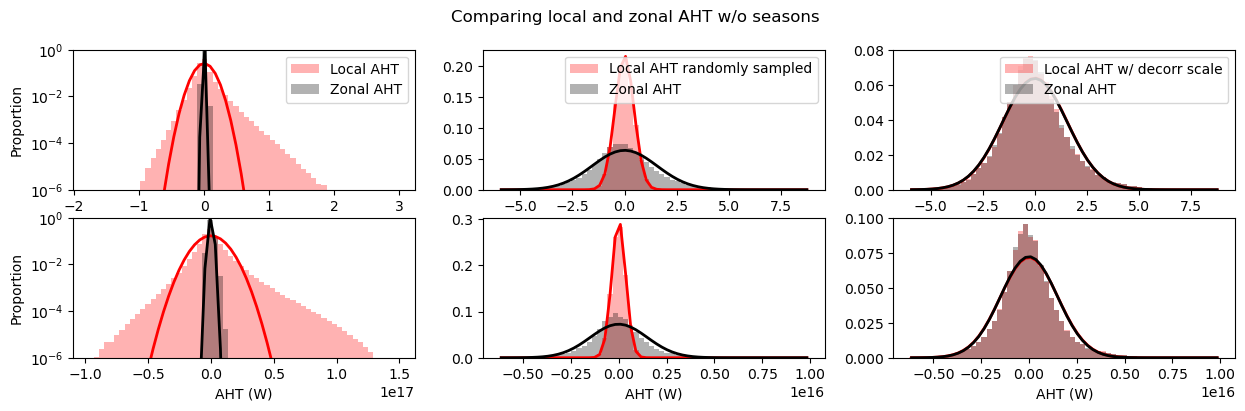

In [45]:
fig, axs = plt.subplots(2, 3, figsize=(15,4))

#eddy_zonal1 = aht_ds.eddy_aht.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht.sel(latitude=which_lat2).values.flatten()
eddy_zonal1 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat1).values.flatten()
eddy_zonal2 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat2).values.flatten()

local_color = 'r'
zonal_color = 'k'
num_bins = 60


n_bins00, bin_edges00 = np.histogram(eddy_local1.flatten(), num_bins)

era_fncts.plot_hist_and_gauss(axs[0,0], eddy_local1.flatten(), local_color,
                              which_bins=bin_edges00, label='Local AHT')
era_fncts.plot_hist_and_gauss(axs[0,0], eddy_zonal1, zonal_color,
                              which_bins=bin_edges00, label='Zonal AHT')
axs[0,0].legend(loc=0)


n_bins10, bin_edges10 = np.histogram(eddy_local2.flatten(), num_bins)

era_fncts.plot_hist_and_gauss(axs[1,0], eddy_local2.flatten(), local_color,
                              which_bins=bin_edges10, label='Local AHT')
era_fncts.plot_hist_and_gauss(axs[1,0], eddy_zonal2, zonal_color,
                              which_bins=bin_edges10, label='Zonal AHT')


n_bins01, bin_edges01 = np.histogram(eddy_zonal1, num_bins)

era_fncts.plot_hist_and_gauss(axs[0,1], eddy_local1_samples.flatten(), local_color,
                              which_bins=bin_edges01, label='Local AHT randomly sampled')
era_fncts.plot_hist_and_gauss(axs[0,1], eddy_zonal1, zonal_color,
                              which_bins=bin_edges01, label='Zonal AHT')
axs[0,1].legend(loc=0)

n_bins11, bin_edges11 = np.histogram(eddy_zonal2, num_bins)

era_fncts.plot_hist_and_gauss(axs[1,1], eddy_local2_samples.flatten(), local_color,
                              which_bins=bin_edges11, label='Local AHT randomaly sampled')
era_fncts.plot_hist_and_gauss(axs[1,1], eddy_zonal2, zonal_color,
                              which_bins=bin_edges11, label='Zonal AHT')

n_bins02, bin_edges02 = np.histogram(eddy_zonal1, num_bins)

era_fncts.plot_hist_and_gauss(axs[0,2], eddy_local1_decor_samples.flatten(), local_color,
                              which_bins=bin_edges02, label='Local AHT w/ decorr scale')
era_fncts.plot_hist_and_gauss(axs[0,2], eddy_zonal1, zonal_color,
                              which_bins=bin_edges02, label='Zonal AHT')
axs[0,2].legend(loc=0)

n_bins12, bin_edges12 = np.histogram(eddy_zonal2, num_bins)

era_fncts.plot_hist_and_gauss(axs[1,2], eddy_local2_decor_samples.flatten(), local_color,
                              which_bins=bin_edges12, label='Local AHT w/ decorr scale')
era_fncts.plot_hist_and_gauss(axs[1,2], eddy_zonal2, zonal_color,
                              which_bins=bin_edges12, label='Zonal AHT')

plt.suptitle('Comparing local and zonal AHT w/o seasons')

axs[0,0].set_ylabel('Proportion')
axs[1,0].set_ylabel('Proportion')

axs[1,0].set_xlabel('AHT (W)')
axs[1,1].set_xlabel('AHT (W)')
axs[1,2].set_xlabel('AHT (W)')

axs[0,0].set_yscale('log')
axs[0,0].set_ylim([1e-6, 1])
axs[0,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])
axs[1,0].set_yscale('log')
axs[1,0].set_ylim([1e-6, 1])
axs[1,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])

#plt.savefig('figures/2_22_22_meeting/local_zonal_aht_comparisons_no_seasons_log_scale')

plt.show()

In [398]:
stat, p = sc.shapiro(eddy_local1_samples.flatten())

print(stat)
print(p)

0.9997014999389648
0.1327430158853531


/tdat/tylersc/mini3/envs/jupyter_copy/lib/python3.9/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Make a plot to just show local and zonal AHT distributions

In [46]:
### Load in the necessary single lat AHT files

which_lat1 = 40
which_lat2 = 60

ddir = 'aht_time_series/one_lat/'
eddy_files1 = sorted(glob(ddir + 'eddy_total_' + str(which_lat1) +'*'))
eddy_files2 = sorted(glob(ddir + 'eddy_total_' + str(which_lat2) + '*'))

eddy_data1 = []
for eddy in eddy_files1:
    file_data = np.load(eddy)
    eddy_data1.append(file_data)

eddy_local1 = np.concatenate(eddy_data1) * geometry[era_fncts.get_lat_idx(which_lat1)]

eddy_data2 = []
for eddy in eddy_files2:
    file_data = np.load(eddy)
    eddy_data2.append(file_data)

eddy_local2 = np.concatenate(eddy_data2) * geometry[era_fncts.get_lat_idx(which_lat2)]

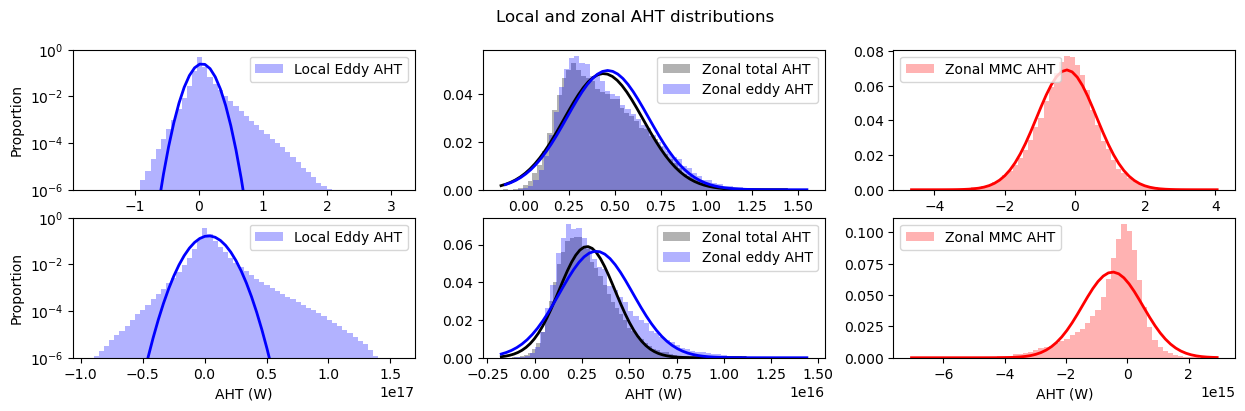

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(15,4))

#eddy_zonal1 = aht_ds.eddy_aht.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht.sel(latitude=which_lat2).values.flatten()
#eddy_zonal1 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat2).values.flatten()

total_color = 'k'
eddy_color ='b'
mmc_color = 'r'

zonal_total_aht1 = aht_ds.total_aht.sel(latitude=which_lat1).values.flatten()
zonal_eddy_aht1 = aht_ds.eddy_aht.sel(latitude=which_lat1).values.flatten()
zonal_mmc_aht1 = aht_ds.mmc_aht.sel(latitude=which_lat1).values.flatten()

era_fncts.plot_hist_and_gauss(axs[0,0], eddy_local1, eddy_color,
                            label='Local Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[0,1], zonal_total_aht1, total_color,
                            label='Zonal total AHT')
era_fncts.plot_hist_and_gauss(axs[0,1], zonal_eddy_aht1, eddy_color,
                            label='Zonal eddy AHT')
era_fncts.plot_hist_and_gauss(axs[0,2], zonal_mmc_aht1, mmc_color,
                            label='Zonal MMC AHT')

zonal_total_aht2 = aht_ds.total_aht.sel(latitude=which_lat2).values.flatten()
zonal_eddy_aht2 = aht_ds.eddy_aht.sel(latitude=which_lat2).values.flatten()
zonal_mmc_aht2 = aht_ds.mmc_aht.sel(latitude=which_lat2).values.flatten()

era_fncts.plot_hist_and_gauss(axs[1,0], eddy_local2, eddy_color,
                            label='Local Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[1,1], zonal_total_aht2, total_color,
                            label='Zonal total AHT')
era_fncts.plot_hist_and_gauss(axs[1,1], zonal_eddy_aht2, eddy_color,
                            label='Zonal eddy AHT')
era_fncts.plot_hist_and_gauss(axs[1,2], zonal_mmc_aht2, mmc_color,
                            label='Zonal MMC AHT')


axs[0,0].legend(loc=0)
axs[1,0].legend(loc=0)
axs[0,1].legend(loc=0)
axs[1,1].legend(loc=0)
axs[0,2].legend(loc=0)
axs[1,2].legend(loc=0)

axs[0,0].set_yscale('log')
axs[0,0].set_ylim([1e-6, 1])
axs[0,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])
axs[1,0].set_yscale('log')
axs[1,0].set_ylim([1e-6, 1])
axs[1,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])
#n_bins12, bin_edges12 = np.histogram(eddy_zonal2, num_bins)

#era_fncts.plot_hist_and_gauss(axs[1,2], eddy_local2_decor_samples.flatten(), local_color,
                             # which_bins=bin_edges12, label='Local AHT w/ decorr scale')
#era_fncts.plot_hist_and_gauss(axs[1,2], eddy_zonal2, zonal_color,
                              #which_bins=bin_edges12, label='Zonal AHT')

plt.suptitle('Local and zonal AHT distributions')

axs[0,0].set_ylabel('Proportion')
axs[1,0].set_ylabel('Proportion')

axs[1,0].set_xlabel('AHT (W)')
axs[1,1].set_xlabel('AHT (W)')
axs[1,2].set_xlabel('AHT (W)')

#plt.savefig('figures/2_22_22_meeting/local_zonal_aht_distributions_log_scale')

plt.show()

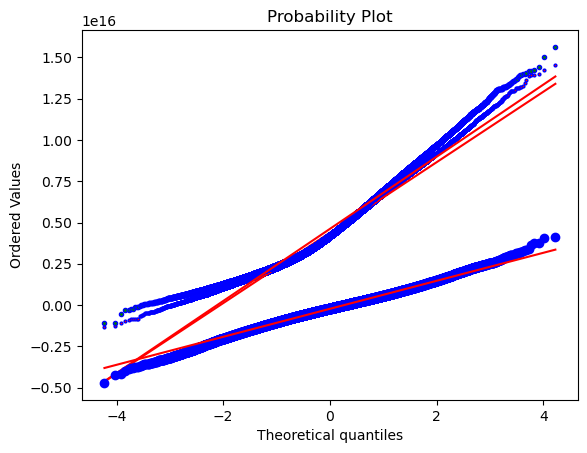

In [491]:
fig = plt.figure()
ax = fig.add_subplot(111)

sc.probplot(zonal_total_aht1, dist='norm', plot=plt)
sc.probplot(zonal_eddy_aht1, dist='norm', plot=plt)
sc.probplot(zonal_mmc_aht1, dist='norm', plot=plt)


ax.get_lines()[0].set_markersize(2)
ax.get_lines()[0].set_markerfacecolor('red')

ax.get_lines()[2].set_markerfacecolor('green')
ax.get_lines()[2].set_markersize(3)

plt.show()

### Plot of a bunch of lats to show danger of lumping latitudes together

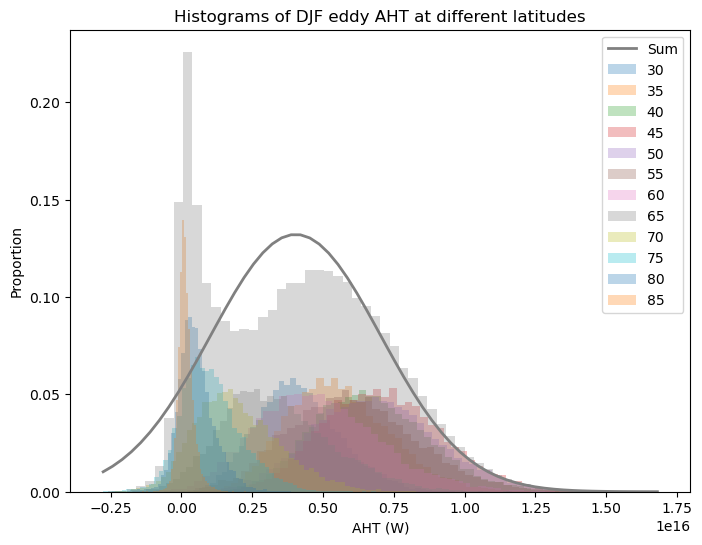

In [445]:
plt.figure(figsize=(8,6))

all_data = []

eddy_aht_season = aht_ds.eddy_aht.groupby('time.season')['DJF']
#for which_lat in range(-89, -30, 5):
for which_lat in range(30, 89, 5):
    lat_width = (geometry[era_fncts.get_lat_idx(which_lat)] * g)
    #eddy_aht = aht_ds.eddy_aht.sel(latitude=which_lat).values.flatten() / lat_width
    eddy_aht = eddy_aht_season.sel(latitude=which_lat).values.flatten()# / lat_width
    all_data.append(eddy_aht)
    plt.hist(eddy_aht, weights=np.ones(len(eddy_aht)) / len(eddy_aht), bins=60, alpha=0.3, label=str(which_lat))

all_data_values = np.array(all_data).flatten()

era_fncts.plot_hist_and_gauss(plt, all_data_values, 'grey', scale_up=3, label='Sum')
#plt.hist(all_data_values, weights=5*np.ones(len(all_data_values)) / len(all_data_values), bins=60, alpha=0.3, label='Sum')
plt.legend(loc=0)
plt.xlabel('AHT (W)')

plt.ylabel('Proportion')

plt.title('Histograms of DJF eddy AHT at different latitudes')

#plt.savefig('figures/2_8_22_meeting/eddy_aht_pdfs_n_hem_djf')

plt.show()

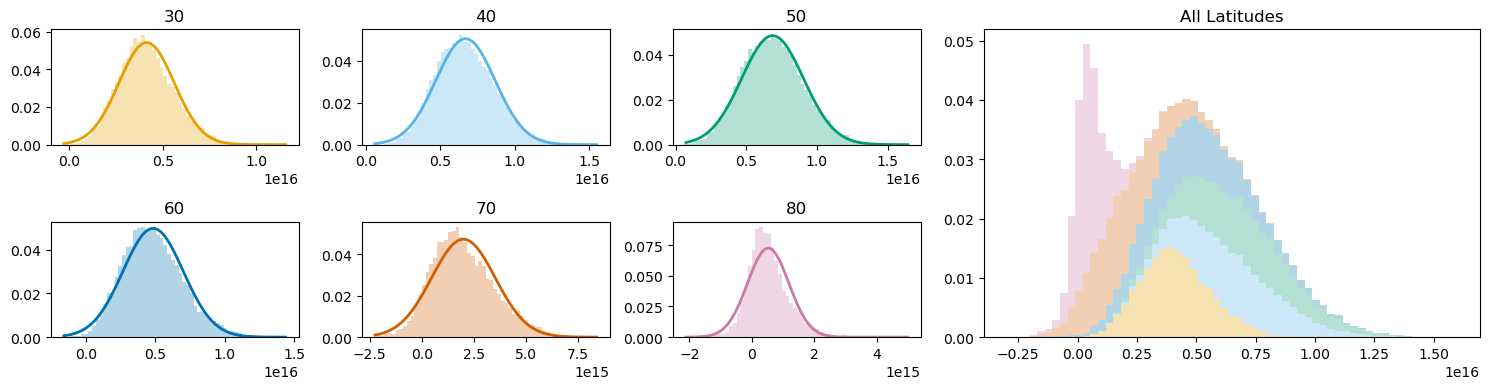

In [100]:
fig, axs = plt.subplots(2, 4, figsize=(15,4), gridspec_kw={'width_ratios': [1, 1, 1, 2]})

all_data = []

eddy_aht_season = aht_ds.eddy_aht.groupby('time.season')['DJF']

lat_list = np.arange(30, 89, 10)

lat_colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7']

lat_color_dict = dict(zip(lat_list, lat_colors))

axs_for_plots = np.delete(axs.reshape(-1), 3)[:6]
for idx, ax in enumerate(axs_for_plots):
    eddy_aht = eddy_aht_season.sel(latitude=lat_list[idx]).values.flatten()
    all_data.append(eddy_aht)
    era_fncts.plot_hist_and_gauss(ax, eddy_aht, lat_colors[idx], label=lat_list[idx])
    
    ax.set_title(lat_list[idx])
    #plt.hist(eddy_aht, weights=np.ones(len(eddy_aht)) / len(eddy_aht), bins=60, alpha=0.3, label=str(which_lat))

gs = axs[0, 3].get_gridspec()
# remove the underlying axes
for ax in axs[0:, -1]:
    ax.remove()
axbig = fig.add_subplot(gs[0:, -1])

num_bins = 60

all_data = np.array(all_data)
which_bins = np.linspace(-.3e16, 1.6e16, num_bins)
# Get the mid points of every bin
bin_middles = (which_bins[1:]+which_bins[:-1])/2.
# Compute the bin-width
bin_width = which_bins[1]-which_bins[0]


probs = np.zeros(((len(lat_list)), num_bins - 1))

for i in range(len(lat_list)):

    n_bins, bin_edges = np.histogram(all_data[i,:].flatten(), which_bins)
    bin_probability = (n_bins/float(n_bins.sum())) / len(lat_list)
    probs[i,:] = bin_probability
    axbig.bar(bin_middles, bin_probability, bottom=np.sum(probs[:i,:], axis=0),
            width=bin_width, color = lat_colors[i], alpha=0.3)
    

axbig.set_title('All Latitudes')

plt.tight_layout()
#plt.savefig('figures/3_15_22_meeting/eddy_aht_pdfs_n_hem_djf_dif_lats')

plt.show()

### See if AHT distributions are different in areas of cold air outbreaks versus not

### First lets get oriented on a map to decide which regions to choose

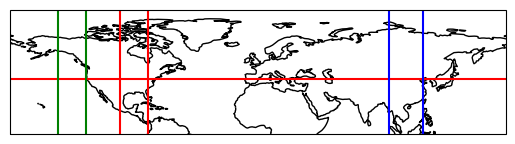

In [5]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.set_ylim([0, 90])
ax.set_xlim([-180, 180])

plt.axhline(40, color='r')

plt.axvline(lons[190], color='b')
plt.axvline(lons[240], color='b')

plt.axvline(lons[430]-360, color='g')
plt.axvline(lons[470]-360, color='g')

plt.axvline(lons[520]-360, color='r')
plt.axvline(lons[560]-360, color='r')

plt.show()

### Make a function that will grab rolling windows for us and see how much of the AHT is done by the top XX% events

In [97]:
def get_extremes_rolling_window(which_lat):
    ddir = 'aht_time_series/one_lat/'
    eddy_files = sorted(glob(ddir + 'eddy_total_' + str(which_lat) +'*'))

    eddy_data = []
    for eddy in eddy_files:
        file_data = np.load(eddy)
        eddy_data.append(file_data)

    eddy_local = np.concatenate(eddy_data)
    
    # Lets loop through each longitude with a 20 deg rolling window
    window_size = 40 #In degrees / 2
    rolling_windows = np.zeros((720, len(eddy_local[:,0]) * 40))
    for i in range(720):
        try:
            #print(np.shape(eddy_local[:,i-20:i+20].flatten()))
            rolling_windows[i,:] = eddy_local[:,i-20:i+20].flatten()
        except:
            #print(i)
            pass
        
    extreme_ratio = np.zeros(720)

    for i in range(720):
        rolling_sorted = np.sort(rolling_windows[i,:])
        rolling_window_top_5_perc = rolling_sorted[int(0.95 * len(rolling_sorted)):]

        extreme_ratio[i] = np.sum(rolling_window_top_5_perc) / np.sum(rolling_sorted)
    
    return extreme_ratio

### Choose some latitudes and run the function

In [98]:
test_lats = [35, 40, 45, 50, 55, 60, 65, 70]

extreme_ratios = np.zeros((len(test_lats), 720))
for i in range(len(test_lats)):
    one_lat = test_lats[i]
    extreme_ratios[i,:] = get_extremes_rolling_window(one_lat)

<ipython-input-97-f5e24f663b8f>:29: RuntimeWarning: invalid value encountered in double_scalars
  extreme_ratio[i] = np.sum(rolling_window_top_5_perc) / np.sum(rolling_sorted)


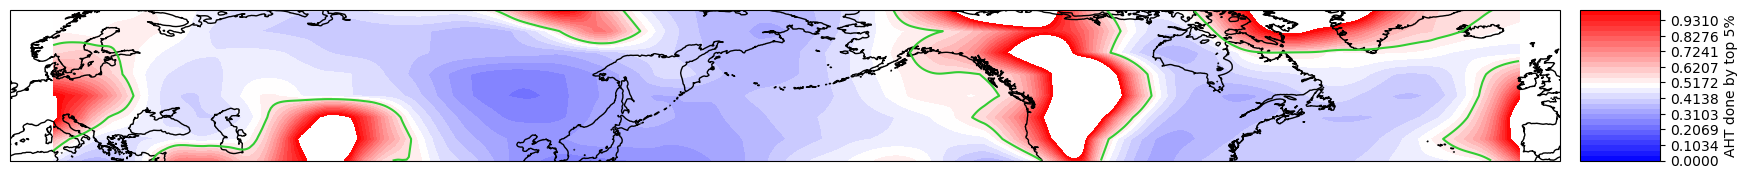

In [101]:
fig=plt.figure(figsize=(20,30))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()

contf = ax.contourf(lons, test_lats, extreme_ratios, levels=np.linspace(0, 1, 30), cmap='bwr', transform=ccrs.PlateCarree())
ax.contour(lons, test_lats, extreme_ratios, levels=[0.55], colors='limegreen', transform=ccrs.PlateCarree())

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.04
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])


plt.colorbar(contf, cax=pos_cax, label='AHT done by top 5%')

#plt.savefig('figures/3_15_22_meeting/eddy_aht_top_5_perc_local_percent')
plt.show()